dataset:https://www.kaggle.com/datasets/kazanova/sentiment140

In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate, Attention, Bidirectional, GlobalAveragePooling1D
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin-1", header=None)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [4]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
data.columns = ["target", "ids", "date", "flag", "user", "text"]

In [6]:
data = data[["target", "text"]]

In [7]:
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+", "", t) 
    t = re.sub(r"[^a-zA-Z\s]", "", t)  
    t = re.sub(r"\s+", " ", t).strip()  
    return t

data["text"] = data["text"].apply(clean_text)

In [9]:
data["target"] = data["target"].apply(lambda x: 0 if x == 0 else 1)

In [10]:
MAX_WORDS = 50000
MAX_LEN = 60

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(data["text"])

X = tokenizer.texts_to_sequences(data["text"])
X = pad_sequences(X, maxlen=MAX_LEN)
y = data["target"].values

In [11]:
X.shape

(1600000, 60)

In [12]:
y.shape

(1600000,)

In [13]:
inp = Input(shape=(MAX_LEN,), name="input")

In [15]:
emb = Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN, name="embedding")(inp)
emb = SpatialDropout1D(0.2)(emb)

In [16]:
conv3 = Conv1D(128, 3, activation="relu")(emb)
pool3 = GlobalMaxPooling1D()(conv3)

conv4 = Conv1D(128, 4, activation="relu")(emb)
pool4 = GlobalMaxPooling1D()(conv4)

conv5 = Conv1D(128, 5, activation="relu")(emb)
pool5 = GlobalMaxPooling1D()(conv5)

cnn_out = Concatenate(name="cnn_concat")([pool3, pool4, pool5])

In [17]:
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(emb)
att_out = Attention()([lstm_out, lstm_out])
att_out = GlobalAveragePooling1D()(att_out)

In [18]:
merged = Concatenate(name="merged_channels")([cnn_out, att_out])
merged = Dropout(0.5)(merged)
dense = Dense(128, activation="relu")(merged)
out = Dense(1, activation="sigmoid")(dense)

In [19]:
model = Model(inputs=inp, outputs=out)

In [20]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 60)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 60, 128)   │  6,400,000 │ input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 60, 128)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 58, 128)   │     49,280 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 57, 128)   │     65,664 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 56, 128)   │     82,048 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 256)   │    263,168 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 60, 256)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_concat          │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_channels     │ (None, 640)       │          0 │ cnn_concat[0][0], │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 640)       │          0 │ merged_channels[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     82,048 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,942,337 (26.48 MB)

 Trainable params: 6,942,337 (26.48 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(X, y,batch_size=1024,epochs=15,validation_split=0.2,verbose=1)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3770s 3s/step - accuracy: 0.8114 - loss: 0.4121 - val_accuracy: 0.6766 - val_loss: 0.6539
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3822s 3s/step - accuracy: 0.8448 - loss: 0.3541 - val_accuracy: 0.7288 - val_loss: 0.5805
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3797s 3s/step - accuracy: 0.8600 - loss: 0.3237 - val_accuracy: 0.7262 - val_loss: 0.6105
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3730s 3s/step - accuracy: 0.8726 - loss: 0.2977 - val_accuracy: 0.7435 - val_loss: 0.5796
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3787s 3s/step - accuracy: 0.8832 - loss: 0.2746 - val_accuracy: 0.7251 - val_loss: 0.6688
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3818s 3s/step - accuracy: 0.8914 - loss: 0.2563 - val_accuracy: 0.7279 - val_loss: 0.7280
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3946s 3s/step - accuracy: 0.8980 - loss: 0.2412 - val_accuracy: 0.7158 - val_loss: 0.8006
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3908s 3s/step - accuracy: 0.9030 -

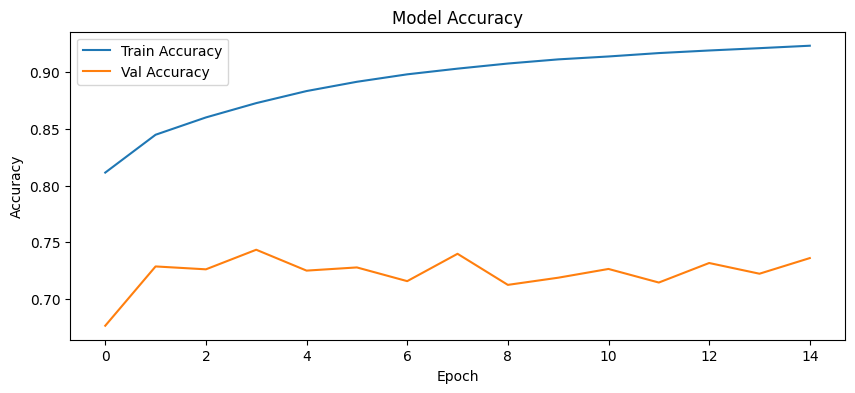

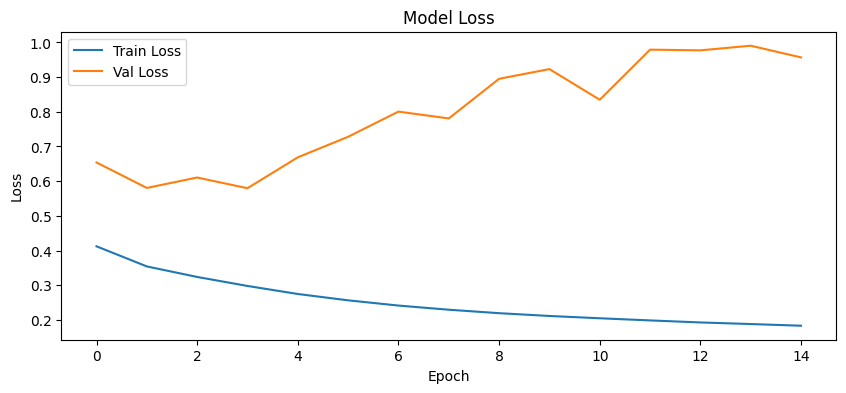

In [23]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test

In [24]:
test_text = ["i love this movie, it was awesome!"]


seq = tokenizer.texts_to_sequences(test_text)
pad = pad_sequences(seq, maxlen=MAX_LEN)
pred = model.predict(pad)


print("Test sentence sentiment:", "Positive" if pred[0][0] > 0.5 else "Negative")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Test sentence sentiment: Positive
